<a href="https://colab.research.google.com/github/RLR-GitHub/MultilayerPerceptron/blob/master/trials/Copy_of_MLP_BACKUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library & Variable Declarations

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
from random import random, seed, uniform

N = 2           # Number of inputs -- x point, y point
I = N + 1
J = 8           # Number of hidden neurons
K = 1           # Number of output neurons 
M = 64         # 10 x 10 -- Number of training patterns (input/output pairs) 
MTEST = 64     # 20 x 20 -- Number of test set inputs
EPOCHS = 500    # Complete training set pass-throughs
LEARNING_RATE = 0.5        # learning rate (rho )

# Setup Matrices

In [0]:
# TRAINING
X_train = np.zeros( shape = ( M, I ) )    # 100 x 2 -- shape = ( r, c ) Training set inputs 
Y_train = np.zeros( shape = ( M, K ) )    # 100 x 1 -- shape = ( r, c ) Training set output vector 
D_train = np.zeros( shape = ( M, K ) )    # 100 x 1 -- shape = ( r, c ) Training set target vector

# TESTING
X_test = np.zeros( shape = ( MTEST, I ) ) # 400 x 2 -- shape = ( r, c ) Test set inputs 
Y_test = np.zeros( shape = ( MTEST, K ) ) # 400 x 1 -- shape = ( r, c ) Test set output vector 
D_test = np.zeros( shape = ( MTEST, K ) ) # 400 x 1 -- shape = ( r, c ) Test set target vector

x = np.zeros( shape = ( I ) ) # 2 -- A single input vector from training set 
y = np.zeros( shape = ( K ) ) # 1 -- Single vector of outupt neurons 
d = np.zeros( shape = ( K ) ) # 1 -- A single target vector from training set 
z = np.zeros( shape = ( J ) ) # 8 -- Vector of hidden layer neurons 

# WEIGHTS
V = np.zeros( shape = ( J, I ) ) # 8 x 2 -- Weight matrix for hidden layer 1
W = np.zeros( shape = ( K, J ) ) # 1 x 8 -- Weight matrix for hidden layer 2

delta = np.zeros( shape = ( K ) ) 
delta_V = np.zeros( shape = ( J, I ) ) # 8 x 2 -- Weight changes for hidden layer 1
delta_W = np.zeros( shape = ( K, J ) ) # 1 x 8 -- Weight changes for hidden layer 2

# OUTPUTS
h = np.zeros( shape = ( J ) ) # 8 -- Weighted sum of hidden layer ( Z )
o = np.zeros( shape = ( K ) ) # 1 -- Weiughted sum of output layer ( Y )

# FUNCTIONS

In [0]:
def randomMatrix( matrix, min_val, max_val, bias = False ):
    r, c = matrix.shape
    random_matrix = np.random.uniform( low = min_val, high = max_val, size = ( r, c ) )
    if( bias == True ): 
        for i in range( r ): random_matrix[ i ][ c - 1 ] = 1
    return( random_matrix )

# Dot Product -- Multiply each of the features with a weight and compute the sum
def dotProduct( matrix, vector ):
    dot_matrix = np.dot( matrix, vector )
    return( dot_matrix )
#==================================================================
def trainingInputs( matrix ): ### MAY BE WRONG
    training_matrix = randomMatrix( matrix, -1.0, 1.0, bias = True )
    return( training_matrix )

def testingInputs( matrix ):
    inc = 0
    r, c = matrix.shape
    numSides = math.sqrt( r )
    step = 2 / ( numSides - 1 )

    for i in range( r ):
        if( ( i % numSides == 0 ) and ( i != 0 ) ): inc = inc + 1
        matrix[ i ][ 1 ] = 1.0 - step * inc               # values from 1 to -1
        matrix[ i ][ 0 ] = -1.0 + step * ( i % numSides ) # values from -1 to 1
        matrix[ i ][ 2 ] = 1
    return( matrix )

def targetOutputs( targets, inputs, area ):
    radius = math.sqrt( area / math.pi )
    r, c = targets.shape

    for i in range( r ):
        radii = math.sqrt( ( inputs[ i ][ 0 ] * inputs[ i ][ 0 ] ) + ( inputs[ i ][ 1 ] * inputs[ i ][ 1 ] ) )
        if( radii <= radius ): targets[ i ][ 0 ] = 1
        else: targets[ i ][ 0 ] = 0

    return( targets )
#==================================================================
def sigmoidActivation( net ):
    n = net.size
    sig_vec = np.zeros( shape = ( n ) )

    for i in range( n ):
        sig_vec[ i ] = 1 / ( 1 + math.exp( -1 * net[ i ] ) )
    
    return( sig_vec )


def weightChanges_W( delta, z, lr = LEARNING_RATE ):
    delta_W = np.zeros( shape = ( K, J ) )

    for j in range( J ): 
        delta_W[ 0 ][ j ] = lr * delta * z[ j ] 

    return( delta_W )

def weightChanges_V( W, delta, z, x, lr = LEARNING_RATE ):
    delta_V = np.zeros( shape = ( J, I ) )

    for j in range( J ):
        summation = delta * W[ 0 ][ j ]
        for i in range( I ):
            # Derivation of y * ( 1 - Y ) helps smooth out sigmoid curve jerking
            delta_V[ j ][ i ] = lr * z[ j ] * ( 1 - z[ j ] ) * x[ i ] * summation 
            
    return( delta_V )

def updateWeights( delta_matrix, matrix ):
    r, c = matrix.shape
    
    for i in range( r ): 
        for j in range( c ): 
            matrix[ i ][ j ] = delta_matrix[ i ][ j ] + matrix[ i ][ j ]

    return( matrix )
#==================================================================

def printMatrix( matrix, mat2, string ):
    size = matrix.size 
    fig, ax = plt.subplots( figsize = ( 5,5 ) )
    ax.set_ylim( [ -1, 1 ] )
    ax.set_xlim( [ -1, 1 ] )
    ax.set_title( string, va = 'bottom' )
    for r in range( size ):
        val = int( round( matrix[ r ][ 0 ] ) )
        if( val == 1 ): ax.text( mat2[ r ][0], mat2[r][1], str( val ), va = 'center', ha = 'center', c = 'r' )
        if( val == 0 ): ax.text( mat2[ r ][0], mat2[r][1], str( val ), va = 'center', ha = 'center', c = 'b' )

# TRAINING PHASE

In [0]:
# GET TRAINING PATTERN VALUES 
X_train = trainingInputs( X_train ) # random points in [-1,1]x[-1,1]
D_train = targetOutputs( D_train, X_train, area = 2.0 )

# INITIALIZE WEIGHT MATRICIES 
V = randomMatrix( V, -10.0, 10.0) # Weight matrix to the hidden layer
W = randomMatrix( W, -10.0, 10.0) # Weight matrix to the output layer 

In [0]:
print( X_train )
print( D_train )
print( h ) 
print( "\nZ",z )
print( "\nO",o ) 
print( "\nY",y )
print( "\nD",d )

print( "\ndelta", delta )
print( "\nE",E )

print( V )
print( "\n",W )

[[ 0.41830021 -0.96950589  1.        ]
 [ 0.13944095  0.8312452   1.        ]
 [-0.72325119  0.89182441  1.        ]
 [ 0.9568262  -0.74111481  1.        ]
 [ 0.73280909 -0.23684792  1.        ]
 [-0.52062115  0.45095506  1.        ]
 [ 0.12112392  0.06303248  1.        ]
 [-0.49483126 -0.92446668  1.        ]
 [ 0.7344915   0.70528805  1.        ]
 [-0.50330073 -0.57738007  1.        ]
 [ 0.22293162  0.23639572  1.        ]
 [-0.22417874 -0.23619818  1.        ]
 [-0.66339393  0.74150783  1.        ]
 [ 0.05376968  0.38974643  1.        ]
 [-0.16886433  0.56213397  1.        ]
 [-0.7138688  -0.38707885  1.        ]
 [ 0.00374135  0.49799247  1.        ]
 [-0.77525165 -0.4155926   1.        ]
 [ 0.88324976 -0.06243871  1.        ]
 [ 0.82777815  0.13522065  1.        ]
 [-0.24524882  0.08569186  1.        ]
 [-0.22114195  0.94094472  1.        ]
 [ 0.61300234  0.32907358  1.        ]
 [ 0.8131945   0.69567914  1.        ]
 [-0.76853683  0.40369493  1.        ]
 [-0.02264151 -0.4514953 

In [0]:
new_lr = 0.5#0.75#LEARNING_RATE

for epoch in range( EPOCHS ):

    Error = 0.0 
    for m in range( M ): 

        # FORWARD PASS
        
        x = X_train[ m ][ : ]                               # Get mth row of X
        d = D_train[ m ][ : ]                               # Get mth row of D 

        h = dotProduct( V, x )                              # Get weighted sums of hidden layer 
        z = sigmoidActivation( h )                          # Get weighted outputs of hidden layer 

        o = dotProduct( W, z )                              # Get weighted sums of output layer 
        y = sigmoidActivation( o )

        Y_train[ m ] = y

        # BACKWARD PASS

        E = ( d - y )                                       # Gradient of error 
        delta = E * y * ( 1 - y )                           # Chnage factor (delta) at output layer       
        Error = Error + ( E * E ) / 2                       # Actual error: mean square loss

        delta_W = weightChanges_W( delta, z, new_lr )       # Compute weight changes of W 
        delta_V = weightChanges_V( W, delta, z, x, new_lr ) # Compute weight changes of V

        W = updateWeights( delta_W, W )                     # Compute weight update of W 
        V = updateWeights( delta_V, V )                     # Compute weight update of V
        
    if( ( epoch + 1 ) % 20 == True ): print( "Epoch: {0:4d}\t".format( int( epoch ) ), "Error: {0:8}\t".format( float( Error ) ), "LR: {0:5f}".format( float( new_lr ) ) )

Epoch:    0	 Error: 15.821344465392002	 LR: 0.500000
Epoch:   20	 Error: 6.132956465198166	 LR: 0.500000
Epoch:   40	 Error: 4.57628161321483	 LR: 0.500000
Epoch:   60	 Error: 3.894826147292543	 LR: 0.500000
Epoch:   80	 Error: 3.500658930005531	 LR: 0.500000
Epoch:  100	 Error: 3.2542632446865727	 LR: 0.500000
Epoch:  120	 Error: 3.090460229905738	 LR: 0.500000
Epoch:  140	 Error: 3.0236744965056017	 LR: 0.500000
Epoch:  160	 Error: 2.982269551054923	 LR: 0.500000
Epoch:  180	 Error: 2.9329955444674356	 LR: 0.500000
Epoch:  200	 Error: 2.8512005707630665	 LR: 0.500000
Epoch:  220	 Error: 2.722264655899225	 LR: 0.500000
Epoch:  240	 Error: 2.583293906534784	 LR: 0.500000
Epoch:  260	 Error: 2.44982710853967	 LR: 0.500000
Epoch:  280	 Error: 2.3251517989996353	 LR: 0.500000
Epoch:  300	 Error: 2.210443823247296	 LR: 0.500000
Epoch:  320	 Error: 2.0979856560591386	 LR: 0.500000
Epoch:  340	 Error: 1.8717626376439873	 LR: 0.500000
Epoch:  360	 Error: 1.179637464178666	 LR: 0.500000
Epoch:

# TESTING PHASE

In [0]:
# GET TESTING PATTERN VALUES 
X_test = testingInputs( X_test )
D_test = targetOutputs( D_test, X_test, area = 2.0 )

Error = 0.0
for m in range( MTEST ): 

    x = X_test[ m ][ : ]                       # Get mth row of X
    d = D_test[ m ][ : ]                       # Get mth row of D 

    h = dotProduct( V, x )                     # Get weighted sums of hidden layer 
    z = sigmoidActivation( h )                 # Get weighted outputs of hidden layer 
    
    o = dotProduct( W, z )                     # Get weighted sums of output layer 
    y = sigmoidActivation( o )                 # Get weighted outputs of output layer 

    Error = Error + ( d - y ) * ( d - y ) / 2  # Actual error: mean square loss
    Y_test[ m ] = y

print( "TestSet Error:", float( Error ) )

TestSet Error: 0.8208084427917953


# RESULTS

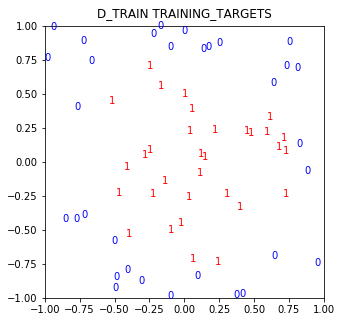

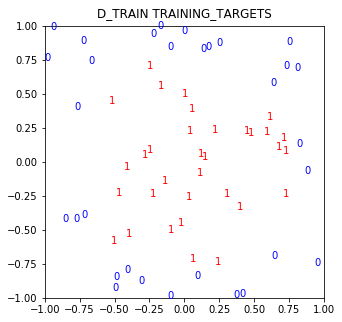

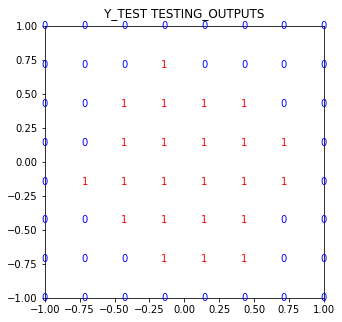

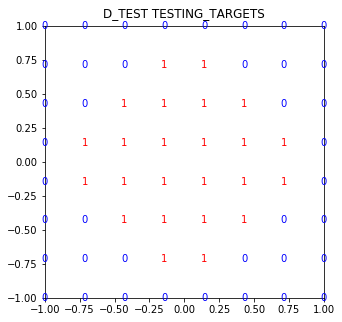

In [0]:
printMatrix( Y_train, X_train, "D_TRAIN TRAINING_TARGETS" )
printMatrix( D_train, X_train, "D_TRAIN TRAINING_TARGETS" ) 
printMatrix(  Y_test,  X_test, "Y_TEST TESTING_OUTPUTS" )
printMatrix(  D_test,  X_test, "D_TEST TESTING_TARGETS" )

# DEBUG

In [0]:
print( h ) 
print( "\nZ",z )
print( "\nO",o ) 
print( "\nY",y )
print( "\nD",d )

print( "\ndelta", delta )
print( "\nE",E )

print( V )
print( "\n",W )

[  6.63764233  -7.47152111  -3.57865119  -3.36918357   1.10362993
  -4.88027955 -15.27245198 -11.21701031]

Z [9.98691602e-01 5.68738385e-04 2.71553272e-02 3.32725596e-02
 7.50939627e-01 7.53764301e-03 2.32947621e-07 1.34433801e-05]

O [-3.18235194]

Y [0.03983528]

D [0.]

delta [-0.00188794]

E [-0.0444496]
[[  6.7662822   -5.76659688  -5.89523675]
 [ -0.81013045  -1.36916652  -8.03055717]
 [  3.08383209  -6.37917733 -13.04166061]
 [ -5.33108939  -8.79796438  -6.83605856]
 [ -7.0146132   -1.79726005   6.32098308]
 [  0.74276064  -5.31880207 -10.94184226]
 [ -7.44977686   2.97587044  -4.84680468]
 [  5.64149498   9.9281334   -6.93037189]]

 [[-8.33550808  7.84366365  8.70068709 -8.94627598  6.85973106  6.37705715
  -9.71305221 -9.30784869]]
